# AI Brain Cancer Detection

##### **Importing Brain Cancer Dataset from Kaggle**

In [ ]:
import kagglehub
import shutil
import os

# Download latest version
path = kagglehub.dataset_download("indk214/brain-tumor-dataset-segmentation-and-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-dataset-segmentation-and-classification


##### **Setting paths**

In [ ]:
# Define local save path
local_path = "./brainCancer_dataset/"

# Ensure the local directory exists
os.makedirs(local_path, exist_ok=True)
# Copy the dataset to the local directory
for item in os.listdir(path):
    s = os.path.join(path, item)
    d = os.path.join(local_path, item)
    if os.path.isdir(s):
        shutil.copytree(s, d, dirs_exist_ok=True)
    else:
        shutil.copy2(s, d)

print(f"Dataset saved at: {local_path}")

print(f"Dataset saved at: {local_path}")

Dataset saved at: ./brainCancer_dataset/
Dataset saved at: ./brainCancer_dataset/


##### **Import Required Libraries for CNN**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


##### **Define Paths and Load Dataset**

In [ ]:
# Correcting paths
train_dir = "./brainCancer_dataset/DATASET/classification/Training"
test_dir = "./brainCancer_dataset/DATASET/classification/Testing"

train_datagen = ImageDataGenerator(
    rescale=1./255,                   # make more simpler
    rotation_range=10,                # small rotations because in medicine 10 degrees is the most a head would be tilted
    width_shift_range=0.05,            # to teach model tumors could be not in that one fixed place
    height_shift_range=0.05,           # to teach model tumors could be not in that one fixed place
    shear_range=0.05,                 # no shear in MRI's. soooo i extremely lowered
    zoom_range=0.15,                  # increased zoom range : Teaches the model to detect patterns regardless of slight differences in scale.
    horizontal_flip=False,            # Medical images should not be flipped.
    fill_mode='nearest',
    brightness_range=[0.8,1.2],  # vary brightness
    validation_split=0.2 #changed the validation split : reserves 20% of training data for validation: Helps you monitor how well the model generalizes to unseen data.

)


test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # a one liner since in testing it we do not have to tweak the image. that is only done in training

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),          # match  model input
    batch_size=32,
    class_mode='categorical',        # we changd this because we have 4 classes and not binary
    shuffle=True                     # random order for each epoch whch breaks up not wanted structure
                                     # also better gradient estimate
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),          #keep as is
    batch_size=32,                   #32 is perfect so we wouldnt overwhelm the program
    class_mode='categorical',
    shuffle=False                    #no need to
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


##### **Create a Simple CNN Model**

In [ ]:
#Building CNN Models

#  Conv2D + MaxPooling: Extract features from the image (edges, textures, shapes)
#  More Conv2D layers: Learn deeper patterns (e.g., tumor structures)
#  Flatten: Convert 2D feature maps to a 1D vector
#  Dropout: Prevent overfitting by randomly dropping neurons
#  Dense: Fully connected layers to make the final prediction
#  Output: Softmax activation gives probability to each of the four classses (glioma, meningioma, no tumor, pituitary)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#Initialize the model
model = Sequential()

#first convolutional layer
model.add(Conv2D(32,(3,3), activation = 'relu', input_shape =(224,224,3)))
#Applies 32 filters with a 3x3 size over the input image (150x150 RGB)

#MaxPooling to reduce spatial size
model.add(MaxPooling2D(pool_size=(2,2)))
#Takes the max value in a 2x2 area - reduces size

#second convolutional layer
model.add(Conv2D(64,(3,3), activation = 'relu'))
#more filters = more features

#MaxPooling
model.add(MaxPooling2D(pool_size=(2,2)))

#third convolutional layer
model.add(Conv2D(128,(3,3),activation = 'relu'))

#MaxPooling
model.add(MaxPooling2D(pool_size = (2,2)))

#Flatten the 2D feature maps into 1D vector
#prepares the data for fully connected layers
model.add(Flatten())

 #Dropout to reduce overfitting
model.add(Dropout(0.5))
# Randomly turns off 50% of neurons during training to prevent memorization

# Fully Connected (Dense) layer
model.add(Dense(128, activation='relu'))

# Output layer: 4 neurons with softmax for categorical classification
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


##### **Train the Model**

In [ ]:
history = model.fit(
    train_generator,
    epochs=5,                       # We start with three then go up slowly
    validation_data=test_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.5035 - loss: 1.2152

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 198s 490ms/step - accuracy: 0.5042 - loss: 1.2134 - val_accuracy: 0.6629 - val_loss: 1.3093
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 85s 473ms/step - accuracy: 0.7736 - loss: 0.6065 - val_accuracy: 0.7574 - val_loss: 0.8173
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 144s 482ms/step - accuracy: 0.7947 - loss: 0.5376 - val_accuracy: 0.7902 - val_loss: 0.5949
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 482ms/step - accuracy: 0.8276 - loss: 0.4505 - val_accuracy: 0.7780 - val_loss: 0.6413
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 84s 467ms/step - accuracy: 0.8352 - loss: 0.4351 - val_accuracy: 0.7910 - val_loss: 0.5754


##### **Evaluate & Test the Model**

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.7115 - loss: 0.7861
Test Accuracy: 0.79


##### **Predict on a New Image**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

classes = ['Glioma', 'Meningioma', 'No tumor', 'Pituitary']

# Corrected predict_image function
def predict_image(path, model, target_size=(224, 224)):  # Adjusted target size to match model input
    img = image.load_img(path, target_size=target_size)   # Load image and resize
    x   = image.img_to_array(img)                       # Convert to array
    x   = np.expand_dims(x, axis=0) / 255.0             # Add batch dimension and normalize
    preds = model.predict(x)                            # Get predictions
    idx   = np.argmax(preds[0])                         # Get index of highest probability
    prob  = preds[0][idx]                               # Get the probability

    # get image, title it and diagnose it
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{classes[idx]} ({prob*100:.1f}%)", fontsize=14, fontweight='bold')
    plt.show()

    return idx, prob # Return index and probability

##### **Image Prediction Run**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


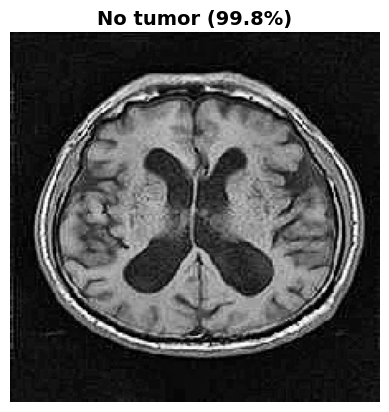

(np.int64(2), np.float32(0.99814045))

In [ ]:
# Example usage
img_path = "/content/brainCancer_dataset/DATASET/classification/Testing/notumor/enh_Te-no_0022.jpg"
predict_image(img_path, model)